In [3]:
import numpy as np
import pickle

# Loading the data

In [4]:
with open('1gpu.pkl','rb') as f:
    objects_1gpu = pickle.load(f)

with open('2gpu.pkl','rb') as f:
    objects_2gpu = pickle.load(f)

with open('4gpu.pkl','rb') as f:
    objects_4gpu = pickle.load(f)

/home/coder/miniconda3/envs/alpa-adaptdl/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-22 20:13:37,279	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [6]:
config_t_iter_1gpu = {k: np.median(np.sort(v)) for k, v in objects_1gpu.config_t_iter.items()}
config_t_iter_2gpu = {k: np.median(np.sort(v)) for k, v in objects_2gpu.config_t_iter.items()}
config_t_iter_4gpu = {k: np.median(np.sort(v)) for k, v in objects_4gpu.config_t_iter.items()}

In [7]:
X_1gpu = np.array(list(config_t_iter_1gpu.keys()))
y_1gpu = np.array(list(config_t_iter_1gpu.values()))

X_2gpu = np.array(list(config_t_iter_2gpu.keys()))
y_2gpu = np.array(list(config_t_iter_2gpu.values()))

X_4gpu = np.array(list(config_t_iter_4gpu.keys()))
y_4gpu = np.array(list(config_t_iter_4gpu.values()))

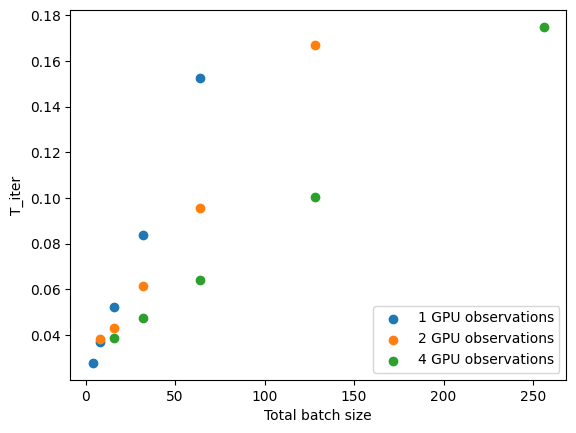

In [8]:
import matplotlib.pyplot as plt

plt.scatter(X_1gpu[:, 0], y_1gpu, label="1 GPU observations")
plt.scatter(X_2gpu[:, 0], y_2gpu, label="2 GPU observations")
plt.scatter(X_4gpu[:, 0], y_4gpu, label="4 GPU observations")
plt.xlabel('Total batch size')
plt.ylabel('T_iter')
# plt.title('Linear regression')
plt.legend()

In [9]:
X = np.vstack([X_1gpu, X_2gpu, X_4gpu])
y = np.hstack([y_1gpu, y_2gpu, y_4gpu])

In [10]:
X.shape, y.shape

((15, 3), (15,))

In [11]:
all_bs = np.array(list(range(4, 256))).reshape(-1, 1)
gpu1 = np.full(all_bs.shape, 1)
gpu2 = np.full(all_bs.shape, 2)
gpu4 = np.full(all_bs.shape, 4)
node1 = np.full(all_bs.shape, 1)

all_bs_configs_1gpu = np.hstack([all_bs, gpu1, node1])
all_bs_configs_2gpu = np.hstack([all_bs, gpu2, node1])
all_bs_configs_4gpu = np.hstack([all_bs, gpu4, node1])

In [12]:
# X_polynomial_term = (X[:, 0] * X[:, 1] * X[:, 2]).reshape(-1, 1)
# X_polynomial = np.hstack([X, X_polynomial_term])

# all_bs_configs_1gpu_polynomial_term = (all_bs_configs_1gpu[:, 0] * all_bs_configs_1gpu[:, 1] * all_bs_configs_1gpu[:, 2]).reshape(-1, 1)
# all_bs_configs_1gpu_polynomial = np.hstack([all_bs_configs_1gpu, all_bs_configs_1gpu_polynomial_term])

# all_bs_configs_2gpu_polynomial_term = (all_bs_configs_2gpu[:, 0] * all_bs_configs_2gpu[:, 1] * all_bs_configs_2gpu[:, 2]).reshape(-1, 1)
# all_bs_configs_2gpu_polynomial = np.hstack([all_bs_configs_2gpu, all_bs_configs_2gpu_polynomial_term])

# all_bs_configs_4gpu_polynomial_term = (all_bs_configs_4gpu[:, 0] * all_bs_configs_4gpu[:, 1] * all_bs_configs_4gpu[:, 2]).reshape(-1, 1)
# all_bs_configs_4gpu_polynomial = np.hstack([all_bs_configs_4gpu, all_bs_configs_4gpu_polynomial_term])

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)
X_polynomial = poly.fit_transform(X)
all_bs_configs_1gpu_polynomial = poly.fit_transform(all_bs_configs_1gpu)
all_bs_configs_2gpu_polynomial = poly.fit_transform(all_bs_configs_2gpu)
all_bs_configs_4gpu_polynomial = poly.fit_transform(all_bs_configs_4gpu)

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor

regressor = LinearRegression()
regressor.fit(X_polynomial, y)

regressor_1gpu = LinearRegression()
regressor_1gpu.fit(X_1gpu, y_1gpu)

regressor_2gpu = LinearRegression()
regressor_2gpu.fit(X_2gpu, y_2gpu)

regressor_4gpu = LinearRegression()
regressor_4gpu.fit(X_4gpu, y_4gpu)

LinearRegression()

In [24]:
from sklearn.metrics import mean_absolute_percentage_error

y_pred = regressor.predict(X_polynomial)

y_1gpu_pred = regressor_1gpu.predict(X_1gpu)
y_2gpu_pred = regressor_2gpu.predict(X_2gpu)
y_4gpu_pred = regressor_4gpu.predict(X_4gpu)

y_error = mean_absolute_percentage_error(y, y_pred)
y_1gpu_error = mean_absolute_percentage_error(y_1gpu, y_1gpu_pred)
y_2gpu_error = mean_absolute_percentage_error(y_2gpu, y_2gpu_pred)
y_4gpu_error = mean_absolute_percentage_error(y_4gpu, y_4gpu_pred)

print(f"y_error: {round(y_error * 100, 2)}%")
print(f"y_1gpu_error: {round(y_1gpu_error * 100, 2)}%")
print(f"y_2gpu_error: {round(y_2gpu_error * 100, 2)}%")
print(f"y_4gpu_error: {round(y_4gpu_error * 100, 2)}%")

y_error: 8.82%
y_1gpu_error: 1.25%
y_2gpu_error: 2.28%
y_4gpu_error: 1.38%


In [15]:
polynomial_1gpu_predictions = regressor.predict(all_bs_configs_1gpu_polynomial)
polynomial_2gpu_predictions = regressor.predict(all_bs_configs_2gpu_polynomial)
polynomial_4gpu_predictions = regressor.predict(all_bs_configs_4gpu_polynomial)

throughput_polynomial_1gpu_predictions = all_bs_configs_1gpu[:, 0] / polynomial_1gpu_predictions
throughput_polynomial_2gpu_predictions = all_bs_configs_2gpu[:, 0] / polynomial_2gpu_predictions
throughput_polynomial_4gpu_predictions = all_bs_configs_4gpu[:, 0] / polynomial_4gpu_predictions

throughput_1gpu_observations = X_1gpu[:, 0] / y_1gpu
throughput_2gpu_observations = X_2gpu[:, 0] / y_2gpu
throughput_4gpu_observations = X_4gpu[:, 0] / y_4gpu

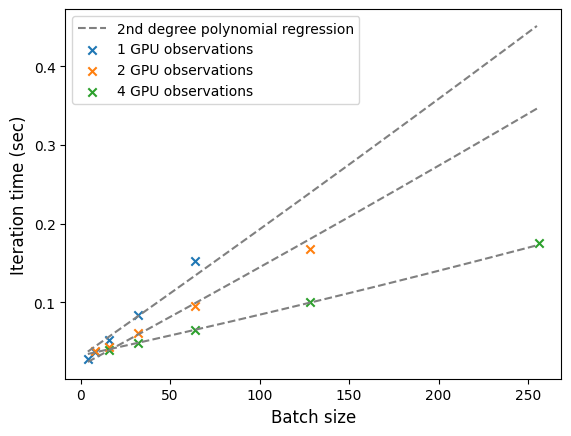

In [16]:
import matplotlib.pyplot as plt

plt.plot(all_bs, polynomial_1gpu_predictions, label="2nd degree polynomial regression", linestyle='dashed', c='grey')
plt.plot(all_bs, polynomial_2gpu_predictions, linestyle='dashed', c='grey')
plt.plot(all_bs, polynomial_4gpu_predictions, linestyle='dashed', c='grey')
plt.scatter(X_1gpu[:, 0], y_1gpu, label="1 GPU observations", marker='x')
plt.scatter(X_2gpu[:, 0], y_2gpu, label="2 GPU observations", marker='x')
plt.scatter(X_4gpu[:, 0], y_4gpu, label="4 GPU observations", marker='x')
plt.xlabel('Batch size', fontsize=12)
plt.ylabel('Iteration time (sec)', fontsize=12)
plt.legend()

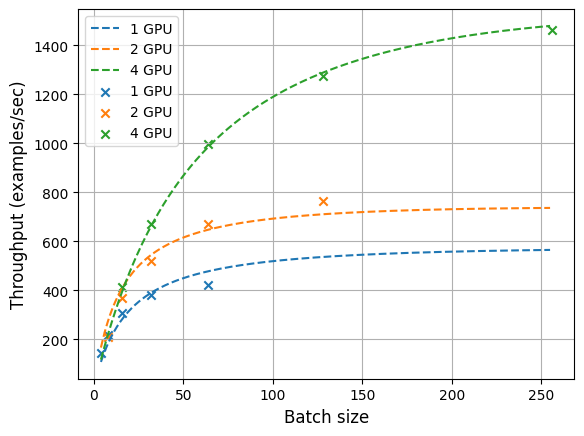

In [17]:
import matplotlib.pyplot as plt

plt.plot(all_bs, throughput_polynomial_1gpu_predictions, label="1 GPU", linestyle='dashed')
plt.plot(all_bs, throughput_polynomial_2gpu_predictions, label="2 GPU", linestyle='dashed')
plt.plot(all_bs, throughput_polynomial_4gpu_predictions, label="4 GPU", linestyle='dashed')
plt.scatter(X_1gpu[:, 0], throughput_1gpu_observations, label="1 GPU", marker='x')
plt.scatter(X_2gpu[:, 0], throughput_2gpu_observations, label="2 GPU", marker='x')
plt.scatter(X_4gpu[:, 0], throughput_4gpu_observations, label="4 GPU", marker='x')
plt.xlabel('Batch size', fontsize=12)
plt.ylabel('Throughput (examples/sec)', fontsize=12)
plt.grid()
plt.legend()

In [18]:
regressor_1gpu_predictions = regressor_1gpu.predict(all_bs_configs_1gpu)
regressor_2gpu_predictions = regressor_2gpu.predict(all_bs_configs_2gpu)
regressor_4gpu_predictions = regressor_4gpu.predict(all_bs_configs_4gpu)

In [19]:
throughput_1gpu_predictions = all_bs_configs_1gpu[:, 0] / regressor_1gpu_predictions
throughput_2gpu_predictions = all_bs_configs_2gpu[:, 0] / regressor_2gpu_predictions
throughput_4gpu_predictions = all_bs_configs_4gpu[:, 0] / regressor_4gpu_predictions

throughput_1gpu_observations = X_1gpu[:, 0] / y_1gpu
throughput_2gpu_observations = X_2gpu[:, 0] / y_2gpu
throughput_4gpu_observations = X_4gpu[:, 0] / y_4gpu

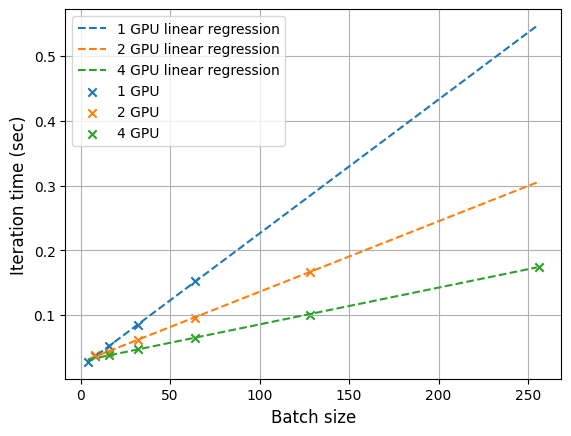

In [20]:
import matplotlib.pyplot as plt

plt.plot(all_bs, regressor_1gpu_predictions, label="1 GPU linear regression", linestyle='dashed')
plt.plot(all_bs, regressor_2gpu_predictions, label="2 GPU linear regression", linestyle='dashed')
plt.plot(all_bs, regressor_4gpu_predictions, label="4 GPU linear regression", linestyle='dashed')
plt.scatter(X_1gpu[:, 0], y_1gpu, label="1 GPU", marker='x')
plt.scatter(X_2gpu[:, 0], y_2gpu, label="2 GPU", marker='x')
plt.scatter(X_4gpu[:, 0], y_4gpu, label="4 GPU", marker='x')
plt.xlabel('Batch size', fontsize=12)
plt.ylabel('Iteration time (sec)', fontsize=12)
plt.grid()
plt.legend()

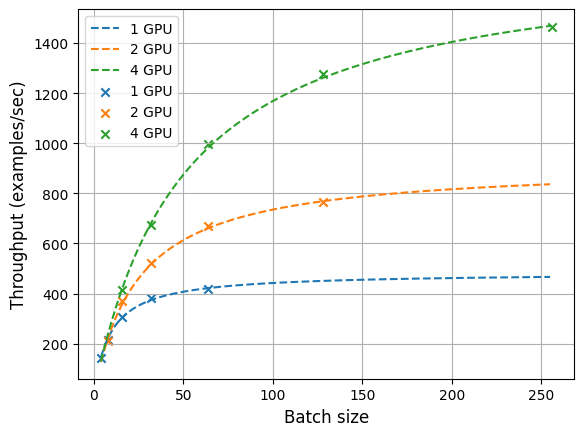

In [21]:
import matplotlib.pyplot as plt

plt.plot(all_bs, throughput_1gpu_predictions, label="1 GPU", linestyle='dashed')
plt.plot(all_bs, throughput_2gpu_predictions, label="2 GPU", linestyle='dashed')
plt.plot(all_bs, throughput_4gpu_predictions, label="4 GPU", linestyle='dashed')
plt.scatter(X_1gpu[:, 0], throughput_1gpu_observations, label="1 GPU", marker='x')
plt.scatter(X_2gpu[:, 0], throughput_2gpu_observations, label="2 GPU", marker='x')
plt.scatter(X_4gpu[:, 0], throughput_4gpu_observations, label="4 GPU", marker='x')
plt.xlabel('Batch size', fontsize=12)
plt.ylabel('Throughput (examples/sec)', fontsize=12)
plt.grid()
plt.legend()

In [22]:
regressor_1gpu.coef_, regressor_2gpu.coef_, regressor_4gpu.coef_

(array([0.00206749, 0.        , 0.        ]),
 array([0.00108904, 0.        , 0.        ]),
 array([0.00056805, 0.        , 0.        ]))

In [39]:
regressor_1gpu.intercept_, regressor_2gpu.intercept_, regressor_4gpu.intercept_

(0.02192572974932519, 0.03077823208046282, 0.02943616079366107)

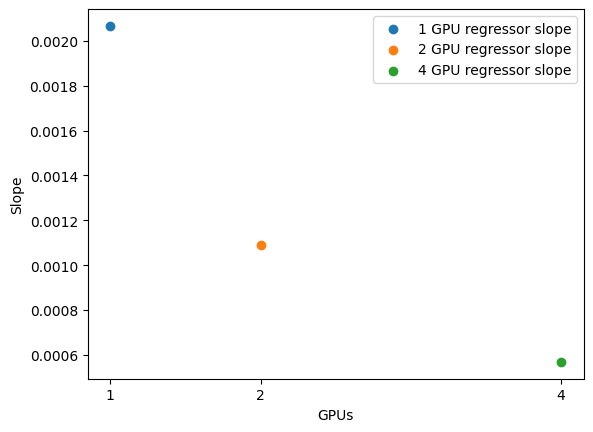

In [37]:
import matplotlib.pyplot as plt

plt.scatter(1, 0.00206749, label="1 GPU regressor slope")
plt.scatter(2, 0.00108904, label="2 GPU regressor slope")
plt.scatter(4, 0.00056805, label="4 GPU regressor slope")
plt.xlabel('GPUs')
plt.ylabel('Slope')
plt.xticks([1, 2, 4])
plt.legend()

### What if batch size (x-axis) is per-GPU batch size (although it is not a thing in Alpa)?

In [32]:
X_1gpu = np.array(list(config_t_iter_1gpu.keys()))
X_1gpu[:,0] = X_1gpu[:,0] / 1
y_1gpu = np.array(list(config_t_iter_1gpu.values()))

X_2gpu = np.array(list(config_t_iter_2gpu.keys()))
X_2gpu[:,0] = X_2gpu[:,0] / 2
y_2gpu = np.array(list(config_t_iter_2gpu.values()))

X_4gpu = np.array(list(config_t_iter_4gpu.keys()))
X_4gpu[:,0] = X_4gpu[:,0] / 4
y_4gpu = np.array(list(config_t_iter_4gpu.values()))

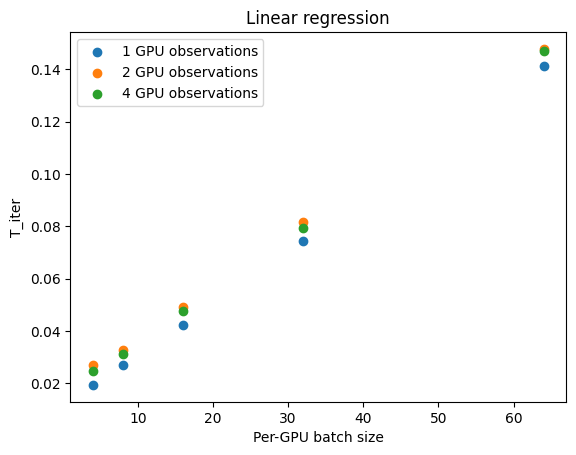

In [33]:
import matplotlib.pyplot as plt

plt.scatter(X_1gpu[:, 0], y_1gpu, label="1 GPU observations")
plt.scatter(X_2gpu[:, 0], y_2gpu, label="2 GPU observations")
plt.scatter(X_4gpu[:, 0], y_4gpu, label="4 GPU observations")
plt.xlabel('Per-GPU batch size')
plt.ylabel('T_iter')
plt.title('Linear regression')
plt.legend()

In [34]:
X = np.vstack([X_1gpu, X_2gpu, X_4gpu])
y = np.hstack([y_1gpu, y_2gpu, y_4gpu])

In [35]:
all_bs = np.array(list(range(64))).reshape(-1, 1)
gpu1 = np.full(all_bs.shape, 1)
gpu2 = np.full(all_bs.shape, 2)
gpu4 = np.full(all_bs.shape, 4)
node1 = np.full(all_bs.shape, 1)

all_bs_configs_1gpu = np.hstack([all_bs, gpu1, node1])
all_bs_configs_2gpu = np.hstack([all_bs, gpu2, node1])
all_bs_configs_4gpu = np.hstack([all_bs, gpu4, node1])

In [36]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X, y)

LinearRegression()

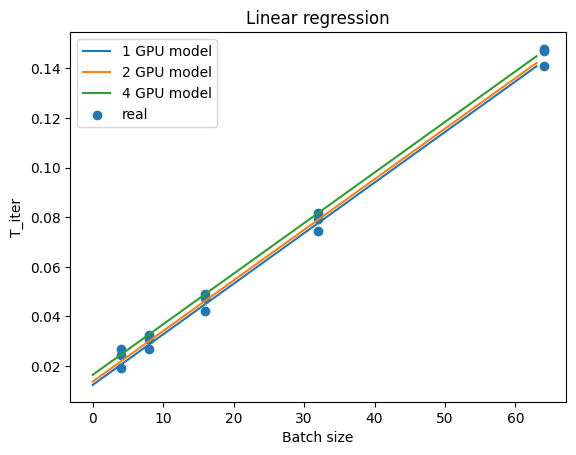

In [37]:
import matplotlib.pyplot as plt

plt.plot(all_bs, regressor.predict(all_bs_configs_1gpu), label="1 GPU model")
plt.plot(all_bs, regressor.predict(all_bs_configs_2gpu), label="2 GPU model")
plt.plot(all_bs, regressor.predict(all_bs_configs_4gpu), label="4 GPU model")
plt.scatter(X[:, 0], y, label="real")
plt.xlabel('Batch size')
plt.ylabel('T_iter')
plt.title('Linear regression')
plt.legend()

# Overfitting Gaussian processes regression:

In [116]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel, RBF, DotProduct, RationalQuadratic

kernel = DotProduct() + RBF() + WhiteKernel(noise_level_bounds=(1e-10, 1e5))
regressor = GaussianProcessRegressor(kernel=kernel)
regressor.fit(X, y)

GaussianProcessRegressor(kernel=DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1))

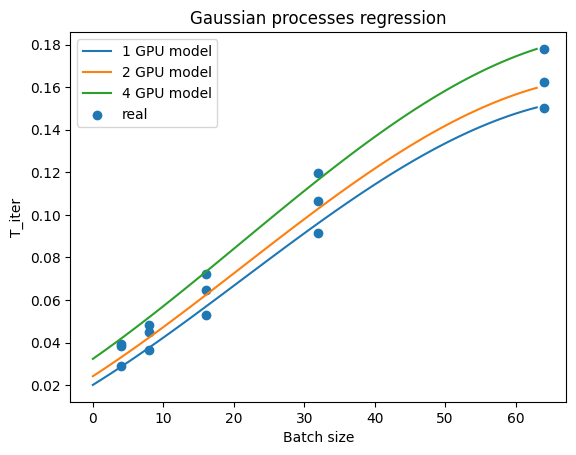

In [117]:
import matplotlib.pyplot as plt

plt.plot(all_bs, regressor.predict(all_bs_configs_1gpu), label="1 GPU model")
plt.plot(all_bs, regressor.predict(all_bs_configs_2gpu), label="2 GPU model")
plt.plot(all_bs, regressor.predict(all_bs_configs_4gpu), label="4 GPU model")
plt.scatter(X[:, 0], y, label="real")
plt.xlabel('Batch size')
plt.ylabel('T_iter')
plt.title('Gaussian processes regression')
plt.legend()